# Characterization of corpus callosum DWI using autoencoder

## Abstract

Corpus Callosum (CC) is a subcortical, white matter structure with great importance in clinical and research studies because its shape and volume are correlated with subject's characteristics and neurodegenerative diseases. CC segmentation is a important step for any medical, clinical or research posterior study. Currently, magnetic resonance imaging (MRI) is the main tool for evaluating brain because it offers the better soft tissue contrast. Particullary, segmentation in MRI difussion modality has great importante given information associated to brain microstruture and fiber composition.

In this work a method for characterization of the CC using a autoencoder (AE) is proposed.

In [1]:
import sys,os, copy, sqlite3, platform, re
main_path = '/home/wilomaku/Repositories/functions/'
paths = [os.path.abspath(main_path), os.path.abspath('{}dtimp'.format(main_path))]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

import numpy as np
import dtimp as DTI
import scipy as scipy
import scipy.misc as misc 
import nibabel as ni
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import genfromtxt

from sklearn.manifold import TSNE

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms
%matplotlib inline

print("Python version: ", platform.python_version())
print("Numpy version: ", np.version.version)
print("Scipy version: ", scipy.__version__)
print("Matplotlib version: ", mpl.__version__)
print("Pytorch version: ", torch.__version__)

/home/wilomaku/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


Python version:  3.6.3
Numpy version:  1.13.3
Scipy version:  0.19.1
Matplotlib version:  2.1.0
Pytorch version:  0.2.0_4


In [2]:
def plot_scatter(spoints, y, arr_color, label, c_map=None):
    fig = plt.figure()
    unique = list(set(y))
    for u in unique:
        index_xy = y==u
        plt.scatter(spoints[index_xy,0], spoints[index_xy,1], c=arr_color[index_xy], marker=markers[u], 
                    label=labels[u], alpha=alphas[u], cmap=c_map)
    if c_map!=None:
        plt.colorbar()
    plt.legend()
    plt.title(label)
    plt.show()

# Creating dataloader

In [3]:
class MRIDataset_list(Dataset):
    
    def __init__(self, list_dirs, n_slice=-1, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            n_slice (int): Slice number. If -1, mid slice is passed.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_dirs = list_dirs
        self.n_slice = n_slice
        self.transform = transform

    def __len__(self):
        return len(self.list_dirs)

    def __getitem__(self, idx):
        base_path = '{}/'.format(self.list_dirs[idx])
        for v_x in ['V1','V2','V3']:
            file_DTI = '{}dti_{}.nii.gz'.format(base_path,v_x)
            vol_dti = ni.load(file_DTI).get_data()

            if 'vol_2d_concat' in locals() or 'vol_2d_concat' in globals():
                vol_2d_concat = np.concatenate((vol_2d_concat,vol_dti),axis=-1)
            else:
                vol_2d_concat = vol_dti

        if self.n_slice == -1:
            slice_ch = int(vol_2d_concat.shape[0]/2)
            vol_2d = vol_2d_concat[slice_ch]
        else:
            vol_2d = vol_2d_concat[self.n_slice]
        
        del(vol_2d_concat)
        
        if self.transform:
            vol_2d = self.transform(vol_2d)

        return vol_2d
    
class ToTensor(object):
    """Numpy-arrays to Tensors."""
    def __call__(self, sample):
        image = sample.swapaxes(0,-1)
        return torch.Tensor(image).type(torch.FloatTensor)

class ToNormalize(object):
    """Normalization between 0 and 1."""
    def __call__(self, sample):
        return sample/torch.max(sample)
    
class ToCrop(object):
    """Crop image to CC region."""
    def __call__(self, sample):
        return sample[:,10:-10,60:-60]#sample[:,10:-10,40:-40]

In [ ]:
#### Only for visualization data
'''
input_path = '/home/wilomaku/Documents/study_char/'
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT acq_folder FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id"
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
dirs_all = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()

all_folders = [os.path.join(base_path,x) for x in dirs_all]

for l_x in ['L1','L2','L3']:
    base_path = '{}/'.format(all_folders[0])
    file_DTI = '{}dti_{}.nii.gz'.format(base_path,l_x)
    vol_dti = ni.load(file_DTI).get_data()
    
    slice_ch = int(vol_dti.shape[0]/2)
    vol_2d = vol_dti[slice_ch]
    print(vol_2d.shape)
    
    plt.imshow(vol_2d,cmap='gray', origin='lower')
    plt.show()

for v_x in ['V1','V2','V3']:
    base_path = '{}/'.format(all_folders[0])
    file_DTI = '{}dti_{}.nii.gz'.format(base_path,v_x)
    vol_dti = ni.load(file_DTI).get_data()
    print(vol_dti.shape)
    slice_ch = int(vol_dti.shape[0]/2)
    vol_2d = vol_dti[slice_ch]
    print(vol_2d.shape)
    if 'vol_2d_concat' in locals() or 'vol_2d_concat' in globals():
        vol_2d_concat = np.concatenate((vol_2d_concat,vol_2d),axis=-1)
    else:
        vol_2d_concat = vol_2d
    
    for grad_x in np.arange(3):
        plt.imshow(vol_2d[:,:,grad_x],cmap='gray', origin='lower')
        plt.show()
print(vol_2d_concat.shape)
'''

In [5]:
input_path = '/home/wilomaku/Documents/study_char/'
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT acq_folder FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id"
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
dirs_all = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()

all_folders = [os.path.join(base_path,x) for x in dirs_all]

grad_ch = 0
n_samples = len(all_folders)

transformed_dataset = MRIDataset_list(list_dirs=all_folders, transform=transforms.Compose([ToTensor(), ToNormalize(),
                                                                                           ToCrop()]))
indices = np.array(range(n_samples))
Cin = transformed_dataset[0].numpy().shape[0] #Input Channels

New dataset size (Leaving out sized-different subjects):  202
1 torch.Size([9, 50, 136]) 0.9999985694885254
2 torch.Size([9, 50, 136]) 1.0
3 torch.Size([9, 50, 136]) 1.0
4 torch.Size([9, 50, 136]) 1.0
5 torch.Size([9, 50, 136]) 0.9999971389770508
6 torch.Size([9, 50, 136]) 1.0
7 torch.Size([9, 50, 136]) 0.9999869465827942
8 torch.Size([9, 50, 136]) 0.999986469745636
9 torch.Size([9, 50, 136]) 0.9999974370002747


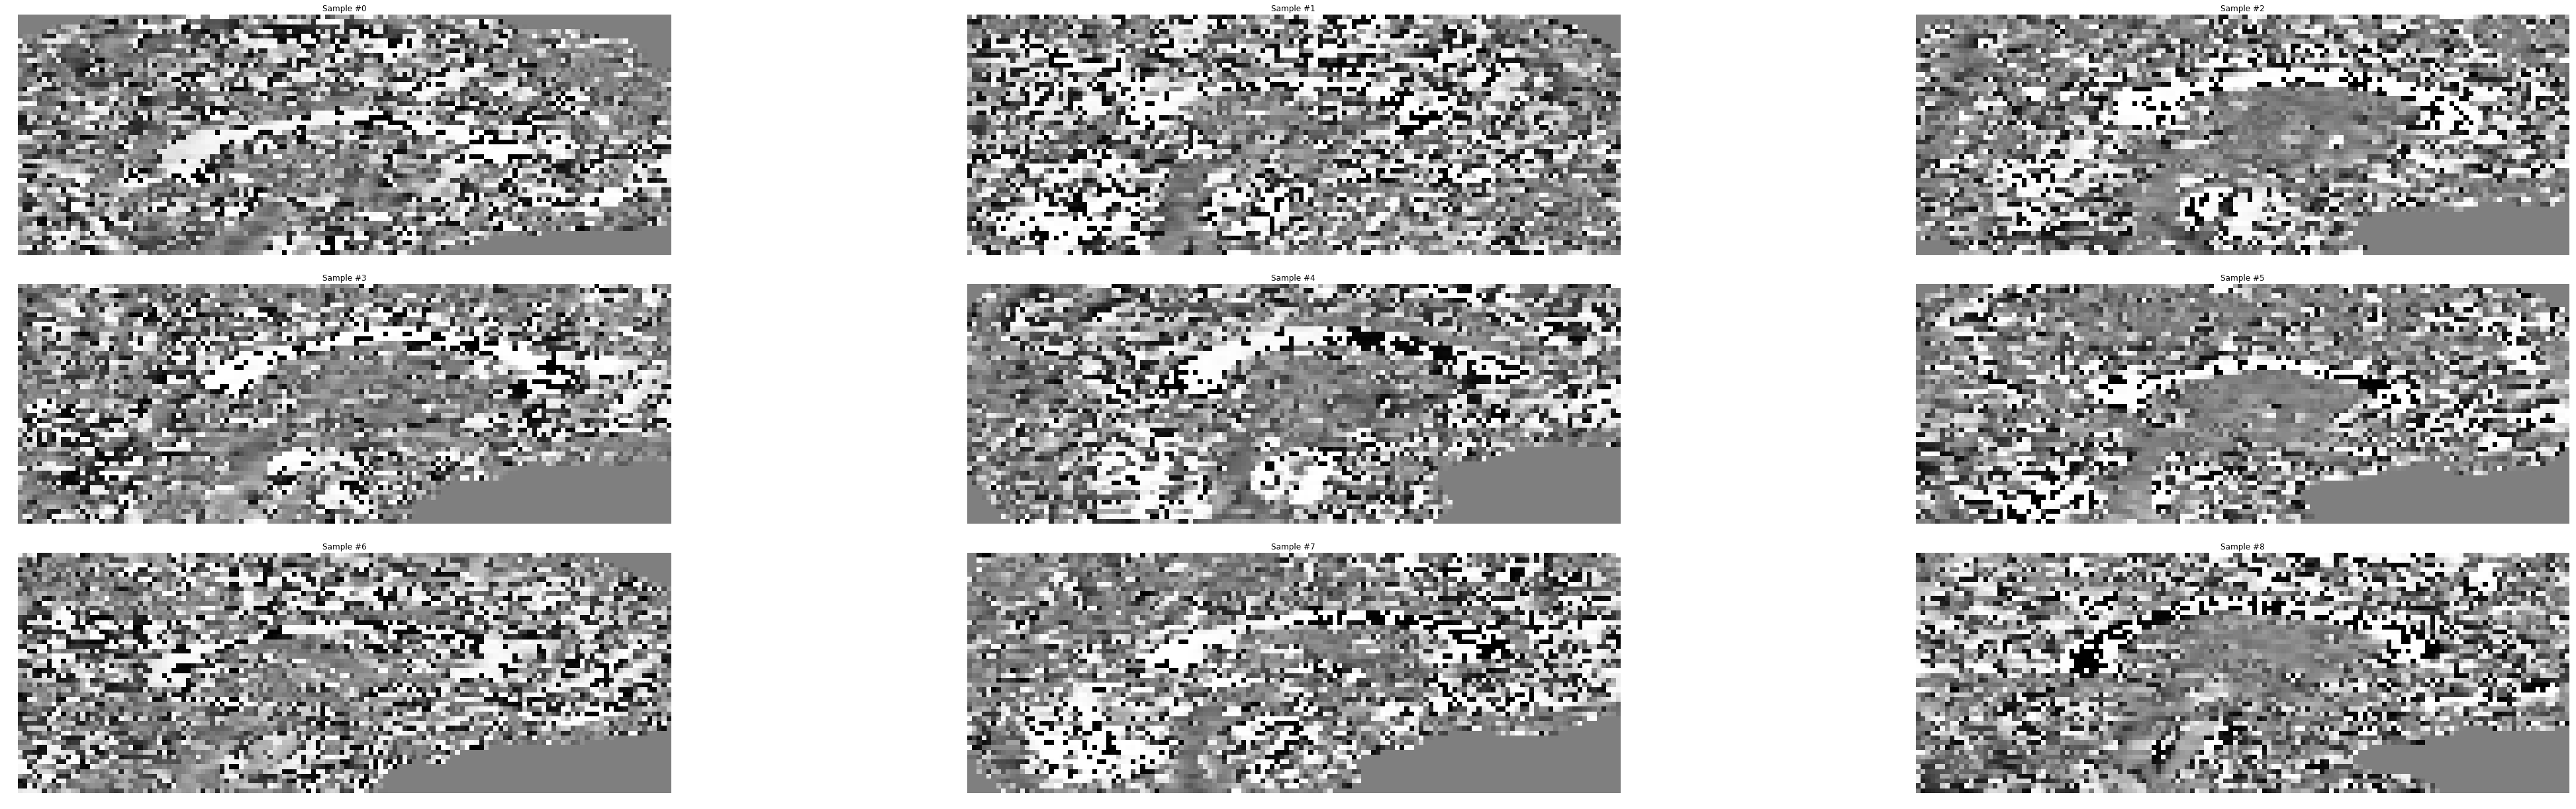

In [6]:
fig = plt.figure(figsize=(60,62))
print('New dataset size (Leaving out sized-different subjects): ', n_samples)
for i in indices:
    sample = transformed_dataset[i]
    print(i+1,sample.size(),torch.max(sample))
    ax = plt.subplot(11, 3, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample.numpy()[grad_ch],cmap='gray', origin='lower')
    if i == 8:
        plt.show()
        break
plt.show()

In [7]:
split = 32 #Number of elements in test set
test_idx = np.random.choice(np.array(indices), size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))

train_sampler = sampler.SubsetRandomSampler(train_idx)
test_sampler = sampler.SubsetRandomSampler(test_idx)

train_loader = DataLoader(transformed_dataset, batch_size=32, shuffle=False, sampler=train_sampler)
test_loader = DataLoader(transformed_dataset, batch_size=32, shuffle=False, sampler=test_sampler)
print('====== Train Dataloader ======')
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched.size())
print('====== Test Dataloader ======')
for i_batch, sample_batched in enumerate(test_loader):
    print(i_batch, sample_batched.size())

====== Train Dataloader ======
0 torch.Size([32, 9, 50, 136])
1 torch.Size([32, 9, 50, 136])
2 torch.Size([32, 9, 50, 136])
3 torch.Size([32, 9, 50, 136])
4 torch.Size([32, 9, 50, 136])
5 torch.Size([10, 9, 50, 136])
====== Test Dataloader ======
0 torch.Size([32, 9, 50, 136])


# Autoencoder

In [8]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(Cin, 64, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.mpool1 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.mpool2 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1)
        self.mpool3 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.mpool4 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.fc_c5 = nn.Linear(32*2*10,3)
        # == Decodification ==
        self.fc_d5 = nn.Linear(3,32*2*10)
        self.deconv4 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.mupool4 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv3 = nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.mupool3 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1,0))
        self.mupool2 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv1 = nn.ConvTranspose2d(64, Cin, kernel_size=3, stride=2, padding=1, output_padding=(1,1))
        self.mupool1 = nn.MaxUnpool2d(kernel_size=2, stride=1)

    def encode(self, x):
        h1, self.ind1 = self.mpool1(self.relu(self.conv1(x)))
        h2, self.ind2 = self.mpool2(self.relu(self.conv2(h1)))
        h3, self.ind3 = self.mpool3(self.relu(self.conv3(h2)))
        h4, self.ind4 = self.mpool4(self.relu(self.conv4(h3)))
        return self.fc_c5(h4.view(-1, 32*2*10))

    def decode(self, y):
        i5 = self.fc_d5(y)
        i4 = self.relu(self.deconv4(self.mupool4(i5.view(-1, 32, 2, 10), self.ind4)))
        i3 = self.relu(self.deconv3(self.mupool3(i4, self.ind3)))
        i2 = self.relu(self.deconv2(self.mupool2(i3, self.ind2)))
        return self.relu(self.deconv1(self.mupool1(i2, self.ind1)))

    def forward(self, x):
        y = self.encode(x)
        return self.decode(y), y

In [9]:
net = autoencoder()
print(net)

autoencoder (
  (conv1): Conv2d(9, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU ()
  (mpool1): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool2): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool3): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool4): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (fc_c5): Linear (640 -> 3)
  (fc_d5): Linear (3 -> 640)
  (deconv4): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mupool4): MaxUnpool2d (size=(2, 2), stride=(1, 1), padding=(0, 0))
  (deconv3): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mupool3): MaxUnpool2d (size=(2, 2), stride=(1, 1), padding=(0, 0))
  (deconv2):

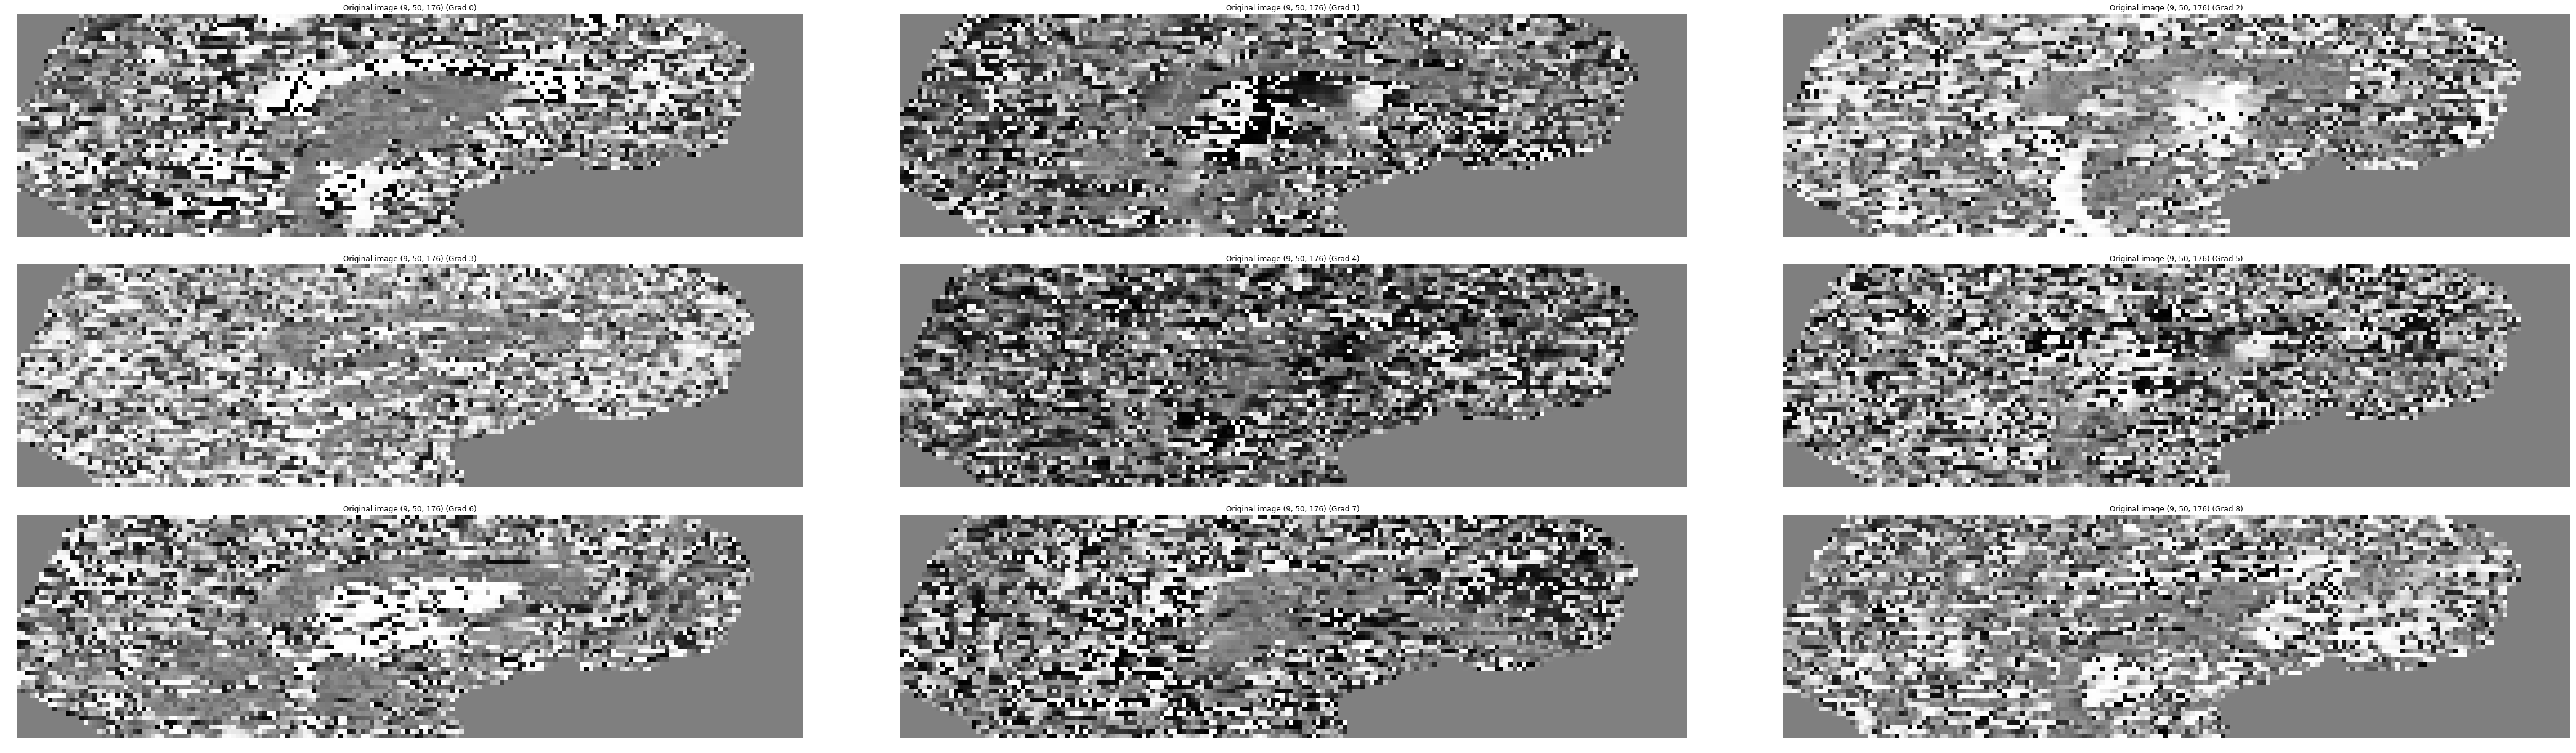

Decod >  torch.Size([32, 9, 50, 176]) Encod >  torch.Size([32, 2])


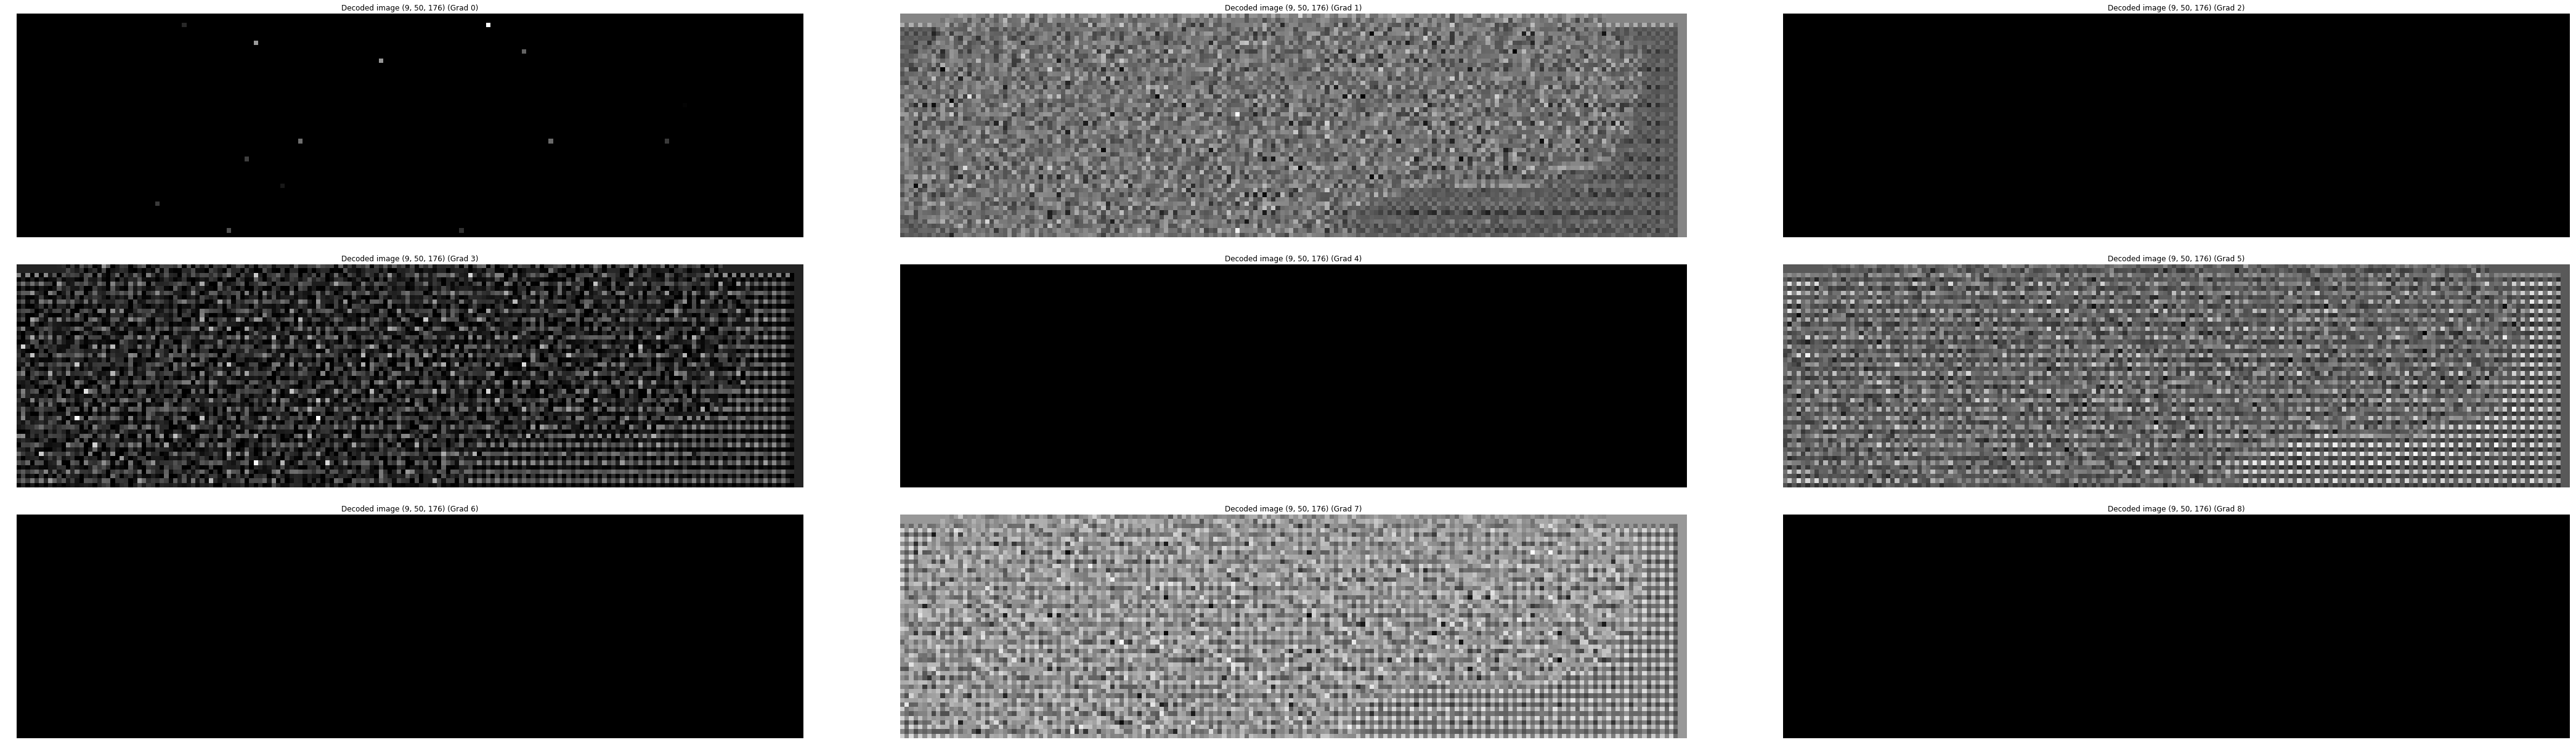

In [8]:
grad_ch = 15

for n_i, sample_batched in enumerate(test_loader):
    or_out = sample_batched.numpy()[0]
    fig = plt.figure(figsize=(60,62))
    for grad in range(Cin):
        ax = plt.subplot(11, 3, grad+1)
        ax.set_title('Original image {} (Grad {})'.format(or_out.shape,grad))
        ax.axis('off')
        plt.tight_layout()
        plt.imshow(or_out[grad],cmap='gray', origin='lower')
    plt.show()
    #######################################################
    dec_out, enc_out = net(Variable(sample_batched))
    print('Decod > ', dec_out.size(), 'Encod > ', enc_out.size())
    pred_out = dec_out.data.numpy()[0]
    fig = plt.figure(figsize=(60,62))
    for grad in range(Cin):
        ax = plt.subplot(11, 3, grad+1)
        ax.set_title('Decoded image {} (Grad {})'.format(pred_out.shape,grad))
        ax.axis('off')
        plt.tight_layout()
        plt.imshow(pred_out[grad],cmap='gray', origin='lower')
    plt.show()
    if n_i == 1:
        break

# Training autoencoder

In [10]:
def train(model,train_loader,valid_loader,loss_fn,optimizer,epochs=10,num_break=5,patience=5,criteria_stop="loss"):
    hist_train_loss = hist_val_loss = hist_train_acc = hist_val_acc = np.array([])
    best_epoch = patience_count = 0

    print("Training starts along %i epoch"%epochs)
    for e in range(epochs):
        correct_train = correct_val = total_train = total_val = 0
        cont_i = loss_t_e = loss_v_e = 0
        for data_train, data_valid in zip(train_loader, valid_loader):
            #if cont_i == num_break:
            #    break

            inputs = data_train
            var_inputs = Variable(inputs)

            predict, encode = model(var_inputs)
            loss = loss_fn(predict, var_inputs)
            loss_t_e += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ##Validating model
            inputs = data_valid
            var_inputs = Variable(inputs)
            predict, encode = model(var_inputs)
            loss_val = loss_fn(predict, var_inputs)
            loss_v_e += loss_val.data[0]

            cont_i += 1

        #Stacking historical
        hist_train_loss = np.hstack((hist_train_loss, loss_t_e/(cont_i*1.0)))
        hist_val_loss = np.hstack((hist_val_loss, loss_v_e/(cont_i*1.0)))
        #if e%10 == 0:
        print('Epoch: ', e, 'train loss: ', hist_train_loss[-1], 'valid loss: ', hist_val_loss[-1])

        #Early stopping by best accuracy or best loss
        if(criteria_stop == "acc"):
            if(hist_val_acc[best_epoch] < hist_val_acc[-1]):
                patience_count = 0
                best_epoch = e
                best_model = copy.copy(model)
        else:
            if(hist_val_loss[best_epoch] > hist_val_loss[-1]):
                patience_count = 0
                best_epoch = e
                best_model = copy.copy(model)

        if(patience_count > patience):
            print("Early stopped")
            break;

        if(e == epochs-1):
            print("Training stopped")
        patience_count += 1

    return(best_model, hist_train_loss, hist_val_loss)

In [11]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())#, lr=0.00001
epochs = 5
patience = 5
max_batch = 32
criteria = "loss"

best_model, loss, loss_test = train(net, train_loader, test_loader, loss_fn, optimizer, epochs = epochs, 
                                     num_break = max_batch, patience = patience, criteria_stop = criteria)

Training starts along 5 epoch


RuntimeError: invalid argument 2: size '[-1 x 640]' is invalid for input of with 14336 elements at /opt/conda/conda-bld/pytorch_1503965122592/work/torch/lib/TH/THStorage.c:37

# Testing model

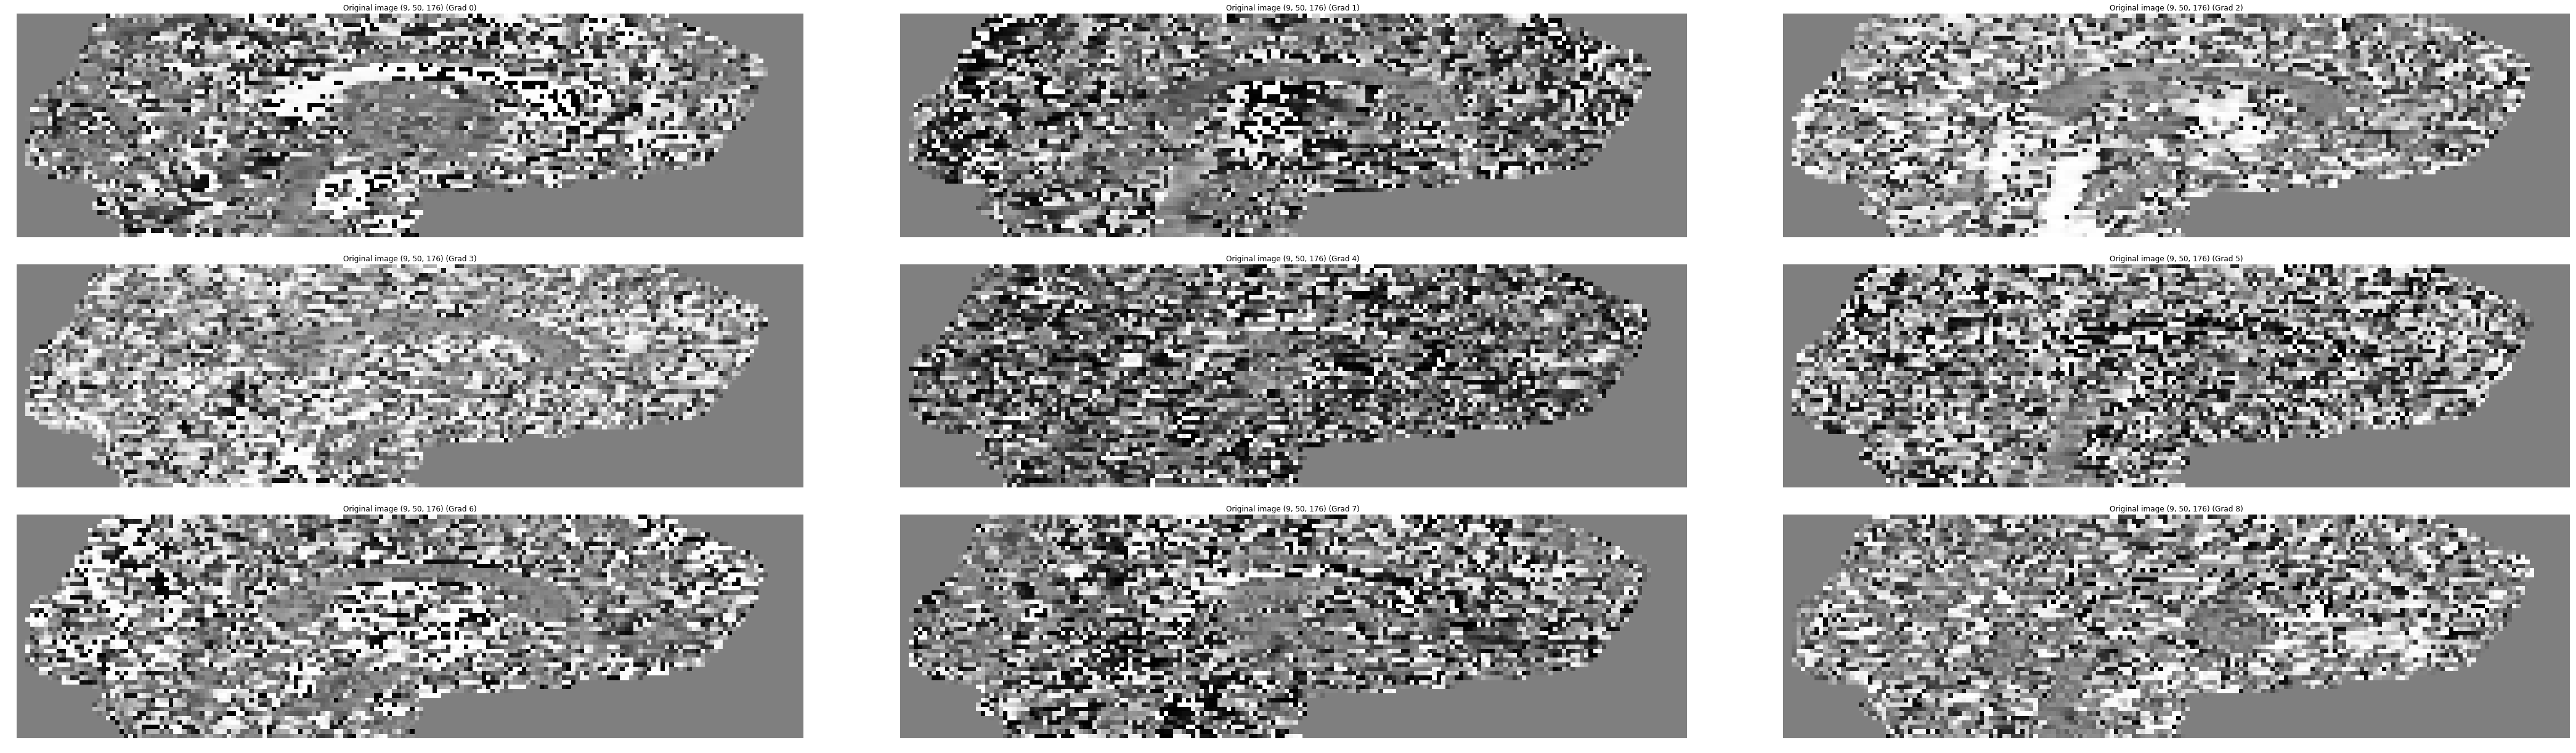

Decod >  torch.Size([32, 9, 50, 176]) Encod >  torch.Size([32, 2])


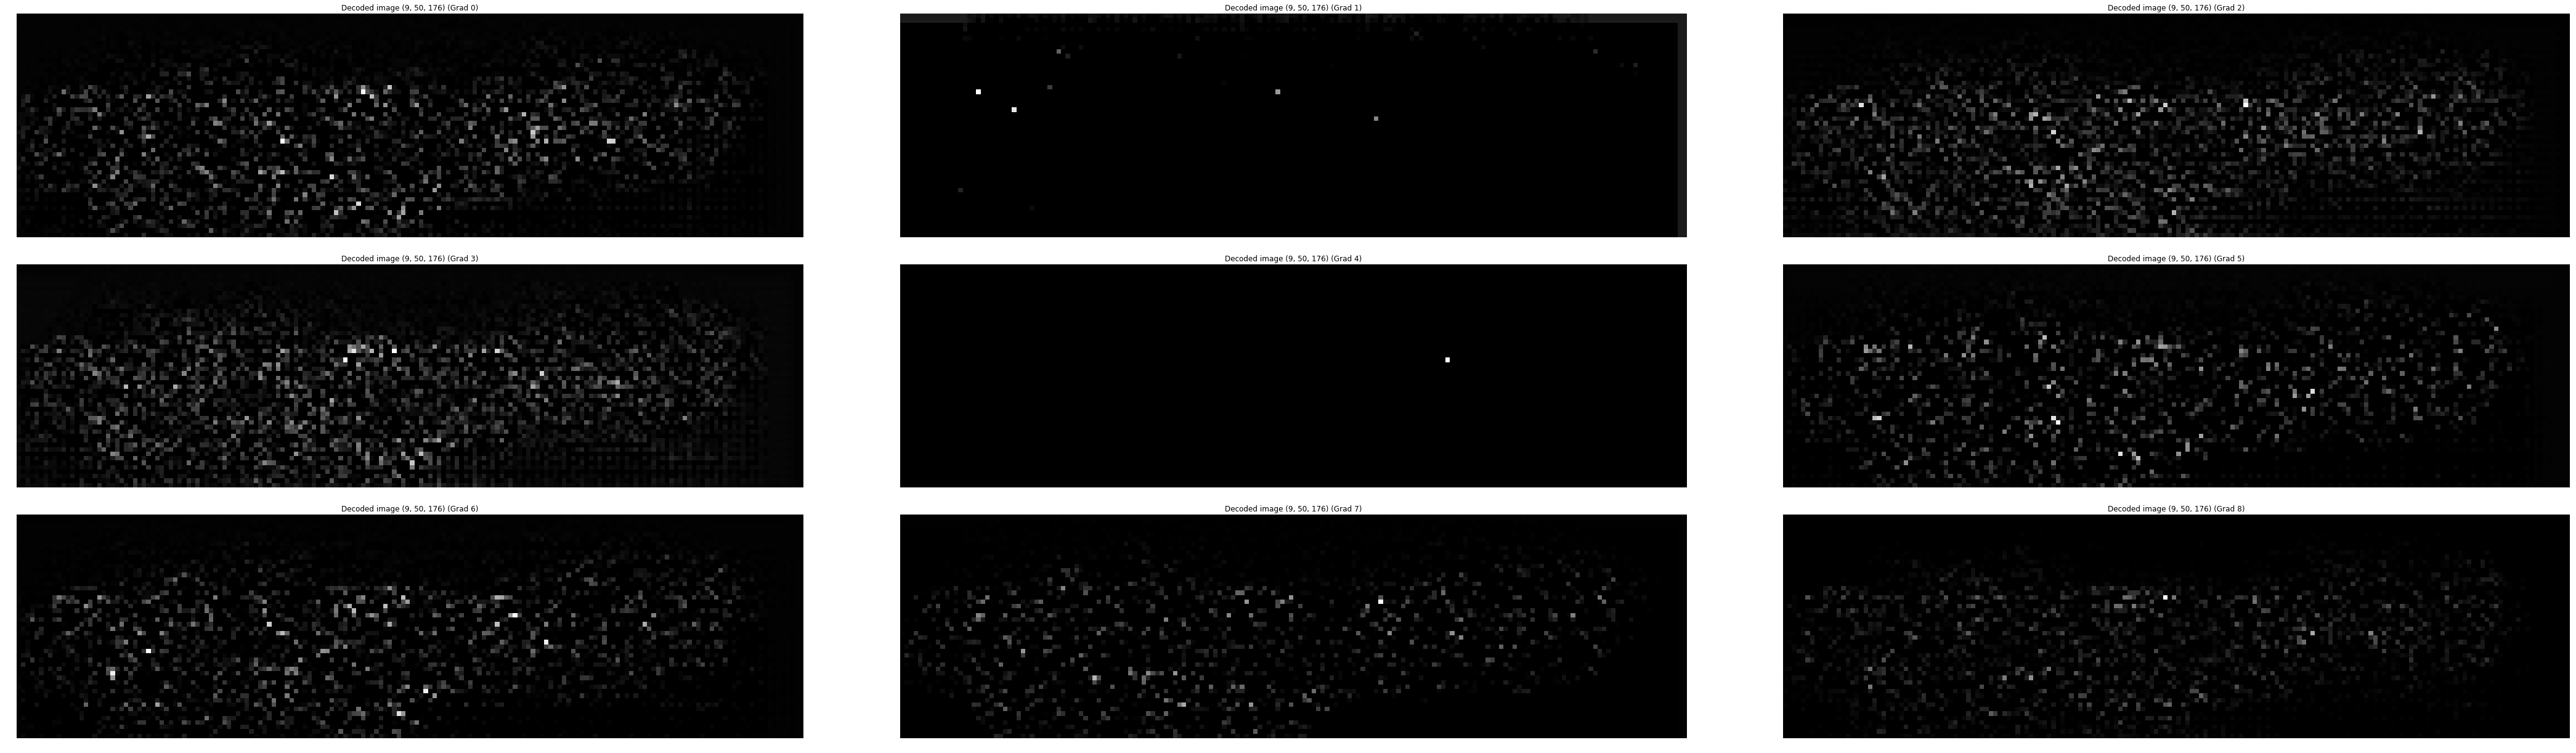

In [12]:
for n_i, sample_batched in enumerate(test_loader):
    or_out = sample_batched.numpy()[0]
    fig = plt.figure(figsize=(60,62))
    for grad in range(Cin):
        ax = plt.subplot(11, 3, grad+1)
        ax.set_title('Original image {} (Grad {})'.format(or_out.shape,grad))
        ax.axis('off')
        plt.tight_layout()
        plt.imshow(or_out[grad],cmap='gray', origin='lower')
    plt.show()
    #######################################################
    dec_out, enc_out = best_model(Variable(sample_batched))
    print('Decod > ', dec_out.size(), 'Encod > ', enc_out.size())
    pred_out = dec_out.data.numpy()[0]
    fig = plt.figure(figsize=(60,62))
    for grad in range(Cin):
        ax = plt.subplot(11, 3, grad+1)
        ax.set_title('Decoded image {} (Grad {})'.format(pred_out.shape,grad))
        ax.axis('off')
        plt.tight_layout()
        plt.imshow(pred_out[grad],cmap='gray', origin='lower')
    plt.show()
    if n_i == 0:
        break

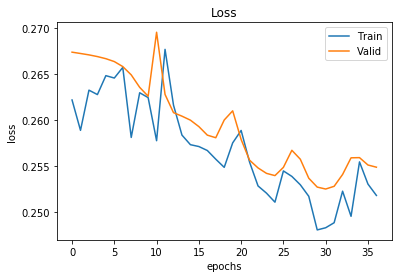

In [13]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(loss, label='Train')
plt.plot(loss_test, label='Valid')
plt.legend()
plt.show()

In [14]:
test_loader_all = next(iter(DataLoader(transformed_dataset, batch_size=n_samples)))

__, enc_out = best_model(Variable(test_loader_all))
print('Encod > ', enc_out.size())

Encod >  torch.Size([202, 2])


In [15]:
#torch.save(best_model, './save_model.model')

# t-SNE for comparison

In [16]:
test_ravel = test_loader_all.numpy().reshape(202,-1)
print('Raveled data shape: ', test_ravel.shape)

test_embedded = TSNE(n_components=2, early_exaggeration=12, learning_rate=500).fit_transform(test_ravel)
print('Embedded data shape: ', test_embedded.shape)

Raveled data shape:  (202, 79200)
Embedded data shape:  (202, 2)


## Gender and Age distribution

202
['F' 'M']
M:  42 F:  160


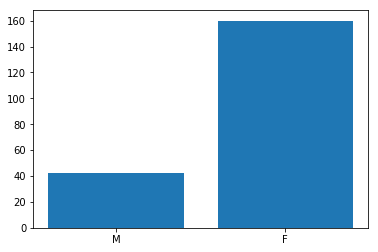

202
Max:  67 Min:  8


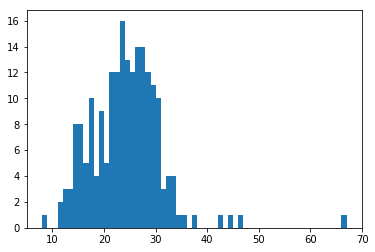

In [17]:
anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT sex, age FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id"
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
list_gender = np.asarray(anon_con_cur)[:,0].flatten()
list_ages = np.asarray(anon_con_cur)[:,1].astype('uint8').flatten()
anon_cur.close()
anon.close()
print(len(list_gender))
print(np.unique(list_gender))
print('M: ',np.sum(list_gender=='M'),'F: ',np.sum(list_gender=='F'))
plt.bar(np.arange(len(np.unique(list_gender))),[np.sum(list_gender=='M'), np.sum(list_gender=='F')])
plt.xticks(np.arange(len(np.unique(list_gender))), np.unique(list_gender)[::-1])
plt.show()

print(len(list_ages))
age_max, age_min = np.max(list_ages), np.min(list_ages)
print('Max: ', age_max,'Min: ', age_min)
plt.hist(list_ages, age_max-age_min)
plt.show()

list_gen_bool = (list_gender == 'M').astype('uint8')

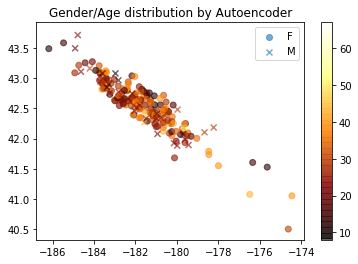

In [18]:
labels = ['F','M']
markers = ['o','x']
alphas = [0.6,0.6]

plot_scatter(enc_out.data.numpy(), list_gen_bool, list_ages, 'Gender/Age distribution by Autoencoder', 'afmhot')

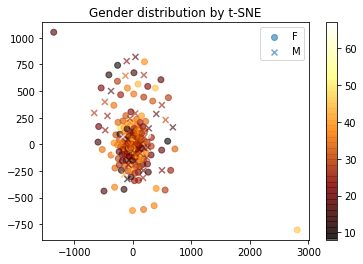

In [19]:
plot_scatter(test_embedded, list_gen_bool, list_ages, 'Gender distribution by t-SNE', 'afmhot')

## Lupus vs control distribution

189


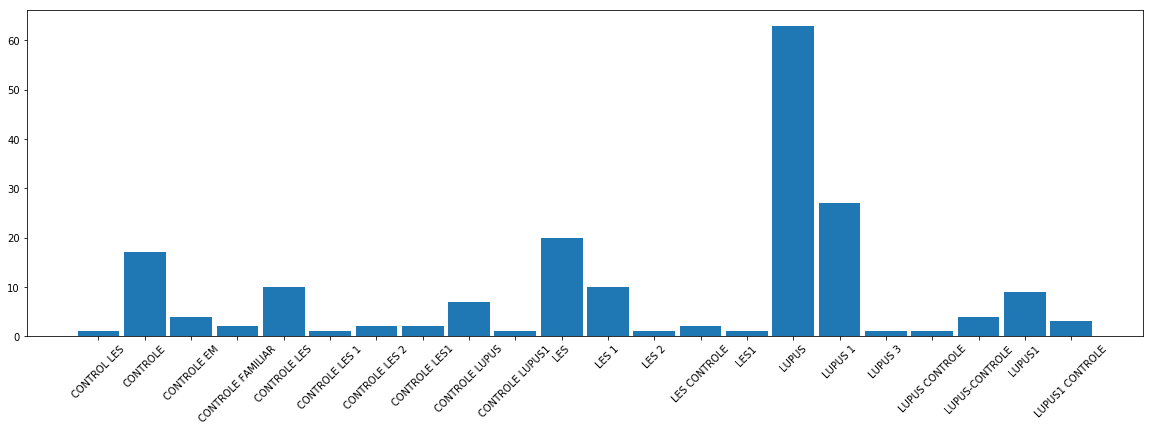

['CONTROL' 'LUPUS']
CONTROL:  57 LUPUS:  132


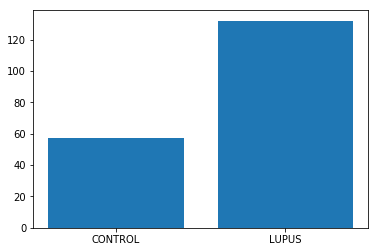

In [20]:
input_path = '/home/wilomaku/Documents/study_char/'
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT study_1 FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id \
       AND %s != 'CRANIO' AND %s != 'CONTROLE MACHADO JOSEPH' AND %s != 'CONTROLE MACHADO' AND %s != 'ENCEFALO ROTINA' \
       AND %s != 'EPILEPSIA' AND %s != 'CONTROLE EPI'" %('study_1','study_1','study_1','study_1','study_1','study_1')
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
list_type = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()
print(len(list_type))
#print(list_type)

n_types = []
for type_suj in np.unique(list_type):
    n_type = np.sum(list_type == type_suj)
    n_types.append(n_type)
#print(n_types)
plt.figure(figsize=(20,6))
plt.bar(np.arange(len(n_types)),n_types, width=0.9)
plt.xticks(np.arange(len(n_types)), np.unique(list_type), rotation=45)
plt.show()

r = re.compile(r'CONTROL.')
for i,type_word in enumerate(list_type):
    if r.search(type_word) != None:
        list_type[i] = 'CONTROL'
    else:
        list_type[i] = 'LUPUS'
#print(list_type)

#print(len(np.unique(list_type)))
print(np.unique(list_type))
print('CONTROL: ',np.sum(list_type=='CONTROL'),'LUPUS: ',np.sum(list_type=='LUPUS'))

plt.bar(np.arange(len(np.unique(list_type))),[np.sum(list_type=='CONTROL'), np.sum(list_type=='LUPUS')])
plt.xticks(np.arange(len(np.unique(list_type))), np.unique(list_type))
plt.show()

In [21]:
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT acq_folder FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id \
       AND %s != 'CRANIO' AND %s != 'CONTROLE MACHADO JOSEPH' AND %s != 'CONTROLE MACHADO' AND %s != 'ENCEFALO ROTINA' \
       AND %s != 'EPILEPSIA' AND %s != 'CONTROLE EPI'" %('study_1','study_1','study_1','study_1','study_1','study_1')
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
dirs_type = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()

sel_folders = [os.path.join(base_path,x) for x in dirs_type]
transformed_dataset = MRIDataset_list(list_dirs=sel_folders, transform=transforms.Compose([ToTensor(), ToNormalize(),
                                                                                           ToCrop()]))
test_loader_all = next(iter(DataLoader(transformed_dataset, batch_size=n_samples)))

list_type_bool = (list_type == 'LUPUS').astype('uint8')
print('LUPUS (1): ',np.sum(list_type_bool==1),'CONTROL (0): ',np.sum(list_type_bool==0))

LUPUS (1):  132 CONTROL (0):  57


In [22]:
__, enc_out = best_model(Variable(test_loader_all))
print('Encod > ', enc_out.size())

Encod >  torch.Size([189, 2])


(189, 2) (189,)


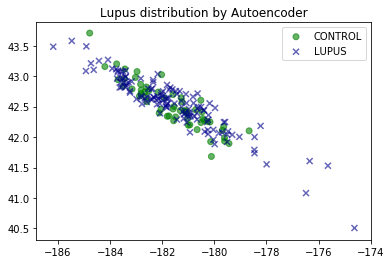

In [23]:
colors = ['darkblue','green']
labels = ['CONTROL','LUPUS']
markers = ['o','x']
alphas = [0.6,0.6]
list_colors = np.zeros(len(list_type_bool)).astype('str')
list_colors[:] = colors[1]
list_colors[list_type_bool.astype('bool')] = colors[0]

print(enc_out.data.numpy().shape, list_type_bool.shape)
plot_scatter(enc_out.data.numpy(), list_type_bool, list_colors, 'Lupus distribution by Autoencoder')

Raveled data shape:  (189, 79200)
Embedded data shape:  (189, 2)


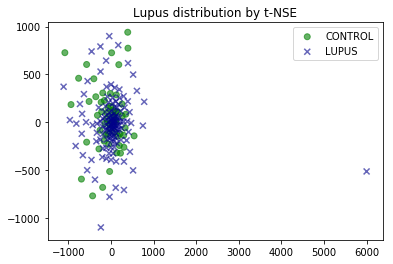

In [24]:
test_ravel = test_loader_all.numpy().reshape(189,-1)
print('Raveled data shape: ', test_ravel.shape)

test_embedded = TSNE(n_components=2, early_exaggeration=12, learning_rate=500).fit_transform(test_ravel)
print('Embedded data shape: ', test_embedded.shape)

plot_scatter(test_embedded, list_type_bool, list_colors, 'Lupus distribution by t-NSE')